In [7]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np

In [30]:
test_data = pd.read_excel(r'C:\Users\markham\OneDrive\Desktop\MFIN7036\group_project\Vectorization+Clustering\data\tset.xlsx')
test_data = test_data.drop(columns=['time','updated','tags'])
test_data['content'] = test_data['title'] + test_data['body']
test_data = test_data.drop(columns=['title','body'])
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.sort_values(by='date')
test_data

,date,content
716,2023-01-01,"['bank', 'korea', 'chief', 'see', 'conflict', ..."
646,2023-01-01,"['saudi', 'share', 'make', 'positive', 'start'..."
647,2023-01-01,"['china', 'home', 'price', 'fall', 'faster', '..."
648,2023-01-01,"['augeraliassime', 'say', 'winning', 'momentum..."
649,2023-01-01,"['toneys', 'injury', 'significant', 'available..."
...,...,...
288,2023-01-04,"['brazil', 'petrobras', 'ceo', 'resigns', 'min..."
434,2023-01-04,"['sam', 'bankmanfried', 'pleads', 'guilty', 'f..."
74,2023-01-11,"['russia', 'war', 'ukraine', 'latest', 'russia..."
482,2023-01-18,"['argentine', 'artist', 'paint', 'inflationhit..."


In [ ]:
# 训练 Word2Vec 模型
model = Word2Vec(sentences=test_data['content'], vector_size=100, window=5, min_count=1, workers=4)

# 定义一个函数，将文本转换为向量
def text_to_vector(text, model):
    vectors = []
    for word in text:
        if word in model.wv:
            vectors.append(model.wv[word])
    if not vectors:
        # 如果文本中没有有效的词向量，返回全零向量
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# 将每条新闻转换为向量
test_data['vector'] = test_data['content'].apply(lambda x: text_to_vector(x, model))



In [49]:
# 将日期转换为日期类型
test_data['date'] = pd.to_datetime(test_data['date'])

# 按日期分组
grouped = test_data.groupby('date')

# 存储每个日期的聚类结果
all_clustered_results = []

# 假设聚类数量为 3，可根据实际情况调整
num_clusters = 2

for date, group in grouped:
    # 提取当天的向量数据
    X = np.array(group['vector'].tolist())
    if len(X) < 3:
        continue  # 样本数量小于 3 时，跳过当前日期的聚类操作
    # 创建 KMeans 模型
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    # 进行聚类
    labels = kmeans.fit_predict(X)

    # 将聚类标签添加到当天的数据中
    group['cluster_label'] = labels
    all_clustered_results.append(group)

# 合并所有日期的聚类结果
final_result = pd.concat(all_clustered_results)

# 将 date 列放到第一列
new_columns = ['date'] + [col for col in final_result.columns if col != 'date']
final_result = final_result[new_columns]

final_result

,date,content,vector,cluster_label
716,2023-01-01,"['bank', 'korea', 'chief', 'see', 'conflict', ...","[0.04346261, -0.07490873, -0.07971009, -0.0245...",0
646,2023-01-01,"['saudi', 'share', 'make', 'positive', 'start'...","[0.047420725, -0.107926324, -0.085319, -0.0678...",1
647,2023-01-01,"['china', 'home', 'price', 'fall', 'faster', '...","[0.056273162, -0.09285705, -0.0847358, -0.0400...",0
648,2023-01-01,"['augeraliassime', 'say', 'winning', 'momentum...","[0.05786155, -0.10163022, -0.082993425, -0.051...",0
649,2023-01-01,"['toneys', 'injury', 'significant', 'available...","[0.048075423, -0.091904424, -0.08602309, -0.03...",0
...,...,...,...,...
292,2023-01-04,"['vietnamese', 'boy', 'trapped', 'concrete', '...","[0.057724386, -0.09277159, -0.09169129, -0.045...",0
291,2023-01-04,"['exclusive', 'nexus', 'venture', 'eye', '700'...","[0.06802983, -0.09187149, -0.09681193, -0.0545...",0
290,2023-01-04,"['india', 'tribunal', 'decline', 'google', 're...","[0.050727338, -0.07617146, -0.087491475, -0.01...",0
288,2023-01-04,"['brazil', 'petrobras', 'ceo', 'resigns', 'min...","[0.048919763, -0.08429699, -0.08477414, -0.015...",0


In [50]:
# 存储每天的轮廓系数和Calinski - Harabasz指数
evaluation_results = []

# 按日期重新分组（因为最终结果已经合并了）
grouped_final = final_result.groupby('date')

for date, group in grouped_final:
    # 提取当天的向量数据
    X = np.array(group['vector'].tolist())
    # 提取当天的聚类标签
    labels = group['cluster_label'].values

    # 计算评估指标需要至少两个不同的簇
    if len(set(labels)) > 1:
        # 计算当天的轮廓系数
        silhouette = silhouette_score(X, labels)
        # 计算当天的Calinski - Harabasz指数
        ch_score = calinski_harabasz_score(X, labels)
    else:
        silhouette = np.nan
        ch_score = np.nan

    evaluation_results.append({
        'date': date,
        'silhouette_score': silhouette,
        'calinski_harabasz_score': ch_score
    })

# 创建评估结果的 DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# 展示结果
print(evaluation_df)

        date  silhouette_score  calinski_harabasz_score
0 2023-01-01          0.486415                74.309093
1 2023-01-02          0.505978               123.591478
2 2023-01-03          0.746600               218.307832
3 2023-01-04          0.534232               179.916665


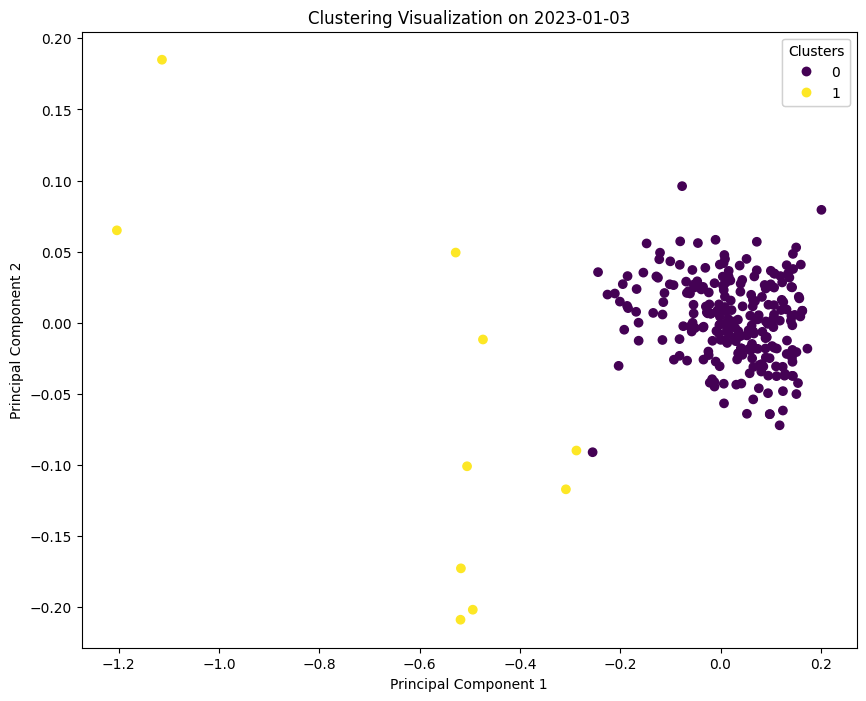

In [51]:
# 筛选出 2023-01-01 这天的数据
date_filter = '2023-01-03'
data_on_date = final_result[final_result['date'] == pd.Timestamp(date_filter)]

# 提取当天的向量数据
X = np.array(data_on_date['vector'].tolist())

# 提取当天的聚类标签
labels = data_on_date['cluster_label'].values

# 使用 PCA 将数据降到二维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 绘制散点图
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)
plt.title(f'Clustering Visualization on {date_filter}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [47]:
final_result[final_result['date'] == pd.Timestamp(date_filter)]

,date,content,vector,cluster_label
138,2023-01-02,"['shark', 'use', 'late', 'flurry', 'goal', 'be...","[0.03279115, -0.107358016, -0.08188677, -0.062...",0
137,2023-01-02,"['france', 'gtt', 'cease', 'activity', 'russia...","[0.056169465, -0.099150866, -0.079268284, -0.0...",1
136,2023-01-02,"['late', 'furuhashi', 'goal', 'earns', 'celtic...","[0.05274435, -0.10227435, -0.0807296, -0.05197...",1
135,2023-01-02,"['least', '14', 'dead', 'armed', 'attack', 'pr...","[0.045437213, -0.10738954, -0.08160691, -0.063...",1
134,2023-01-02,"['israeli', 'foreign', 'minister', 'see', 'abr...","[0.04191582, -0.08060563, -0.07173015, -0.0291...",1
...,...,...,...,...
9,2023-01-02,"['biden', 'promote', 'u', 'infrastructure', 's...","[0.057646338, -0.08913454, -0.083085366, -0.03...",1
8,2023-01-02,"['brazil', 'president', 'lula', 'president', '...","[0.046966482, -0.05293578, -0.082582735, 0.023...",1
14,2023-01-02,"['forest', 'investigating', 'alleged', 'homoph...","[0.0559811, -0.077740885, -0.07636572, -0.0182...",1
6,2023-01-02,"['syria', 'say', 'israel', 'strike', 'put', 'd...","[0.05375907, -0.0921062, -0.07102255, -0.03076...",1
